## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
#Keras (https://keras.io/api/metrics/)
#from tensorflow.keras import layers
#scikit-learn (https://scikit-learn.org/stable/)

from sklearn import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# 1. Pre-processing

## 1.1. Do some early processing of your metadata for easier model training:

### 1.1.1. add new column with the path to image

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
94681,00024418_000.png,No Finding,0,24418,44,M,PA,3040,2544,0.139,0.139,NaN,/data/images_010/images/00024418_000.png
27043,00007046_004.png,Atelectasis,4,7046,42,M,AP,2500,2048,0.171,0.171,NaN,/data/images_004/images/00007046_004.png
69646,00017158_026.png,Effusion,26,17158,58,M,PA,2992,2991,0.143,0.143,NaN,/data/images_008/images/00017158_026.png


### 1.1.2. Add coumn for each decease from the 'Finding Labels' column

In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases
## rather than working directly with the 'Finding Labels' column
##
finding_labels = set('|'.join(all_xray_df['Finding Labels']).split('|'))

for label in finding_labels:
  all_xray_df[label] = all_xray_df['Finding Labels'].apply(lambda x: 1 if label in x else 0)
#drop Findings label once decease has been split in different columns
all_xray_df = all_xray_df.drop(['Finding Labels'], axis=1)
#drop usless columm 
all_xray_df = all_xray_df.drop(['Unnamed: 11'],axis=1)

In [4]:
column_headers = all_xray_df.columns
column_headers

Index(['Image Index', 'Follow-up #', 'Patient ID', 'Patient Age',
       'Patient Gender', 'View Position', 'OriginalImage[Width', 'Height]',
       'OriginalImagePixelSpacing[x', 'y]', 'path', 'Hernia', 'Fibrosis',
       'Atelectasis', 'Infiltration', 'Pleural_Thickening', 'Emphysema',
       'Cardiomegaly', 'No Finding', 'Nodule', 'Edema', 'Consolidation',
       'Pneumonia', 'Mass', 'Pneumothorax', 'Effusion'],
      dtype='object')

### 1.1.3. Add a column with the number of decease per record

In [5]:
decease_columns = finding_labels.copy()
decease_columns.remove('No Finding')
all_xray_df['decease_number']=all_xray_df[decease_columns].sum(axis=1)

### Eliminate wrong input (age not possible) detected within the EDA phase 

In [6]:
all_xray_df = all_xray_df[all_xray_df['Patient Age']<120]

# 2. Case data splitting 

In [7]:
data_size = len(all_xray_df)

## 2.1. Get all normal cases

In [8]:
nodecease_df = all_xray_df[all_xray_df['No Finding']==1]
nodecease_data_size = len( nodecease_df)

## 2.2. Get deceased cases

In [9]:
decease_df = all_xray_df[all_xray_df['No Finding']==0]
decease_data_size = len(decease_df)

## 2.4. Get other decease cases without pneumonia

In [10]:
decease_wo_pneumonia_df = decease_df[decease_df.Pneumonia==0]
decease_wo_pneumonia_data_size = len(decease_wo_pneumonia_df)

## 2.5. Get pneumonia cases

In [11]:
decease_pneumonia_df= decease_df[decease_df.Pneumonia==1]
decease_pneumonia_data_size = len(decease_pneumonia_df)

### 2.5.1. Get pure pneumonial cases

In [12]:
pneumonia_pure_df= decease_pneumonia_df[decease_pneumonia_df.decease_number<2]
pneumonia_pure_data_size = len(pneumonia_pure_df)

### 2.5.2. Get pneumonia with other decease case

In [13]:
pneumonia_other_df = decease_pneumonia_df[decease_pneumonia_df.decease_number>1]
pneumonia_other_data_size = len(pneumonia_other_df)


In [14]:
print(f'Healthy cases                 : {nodecease_data_size}')
print(f'Decease cases                 : {decease_data_size}')
print(f'  Not pneumonia cases         :   {decease_wo_pneumonia_data_size}') 
print(f'  Pneumonia cases             :   {decease_pneumonia_data_size}')
print(f'    -Pure cases               :     {pneumonia_pure_data_size}')
print(f'    -With other deceases cases:     {pneumonia_other_data_size}')
print(f'Total cases                   : {data_size}' )      
      

Healthy cases                 : 60353
Decease cases                 : 51751
  Not pneumonia cases         :   50321
  Pneumonia cases             :   1430
    -Pure cases               :     322
    -With other deceases cases:     1108
Total cases                   : 112104


# 3. Create your training and testing data:

## 3.1. Strategy

We'll have 4 categories:

 - No Decease (NO_DECEASE = 0)
 - Other decease (DECEASE_WO_PNEUMONIA = 1)
 - Pure pneumonia (PNEUMONIA_PURE_DECEASE = 2)
 - Pneumonia eith othrer deceases (PNEUMONIA_OTHER_DECEASE = 3)

Because of the relatively few case of pneumonia case (1430) , we will augment using **geometrical** transformation using Keras data generator to some extends to have at least a ratio of 1/10 of the healthy cases. Since we don't have acces to radiologist to label image and we were not successful to extract distinct patterns when analysing image pixels , we won't use custom augmmentation by blurring or somoothing images.  

On the other side we will tray to reduce by balancing not pneumonial case cross gender and age.

Once, this augmentation done , we will initializing a convolutional neural network (CNN) with class weights calculate with the following formulas:

weight_class_x = (1 / COUNT_CLASS_X) * (TOTAL_SAMPLES) / n

n= number of class
x = [1....n]


## 3.2. Set labels

In [15]:
#nodecease_df=nodecease_df.drop(columns=['category'])
#decease_wo_pneumonia_df=decease_wo_pneumonia_df.drop(columns=['category'])
#pneumonia_pure_df=pneumonia_pure_df.drop(columns=['category'])
#pneumonia_other_df=pneumonia_other_df.drop(columns=['category'])
#nodecease_df['category']

In [16]:
nodecease_df.loc[:,'category']='NO_DECEASE'
decease_wo_pneumonia_df.loc[:,'category']='DECEASE_WO_PNEUMONIA'
pneumonia_pure_df.loc[:,'category']='PNEUMONIA_PURE_DECEASE'
pneumonia_other_df.loc[:,'category']='PNEUMONIA_OTHER_DECEASE'

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


## 3.2. Data preparation

## 3.2.1. Function for data augmentation definitions

In [17]:
# default no transformation


def make_generator(df,rescale,
                   h_flip,
                   h_shift_range,
                   w_shift_range,
                   rotation_range,
                   shear_range,
                   zoom_range,
                   x_col,
                   y_col,
                   target_size,
                   batch_size,
                   classes,
                   class_mode = 'sparse'):
    idg = ImageDataGenerator(rescale=rescale,
                             horizontal_flip = h_flip,
                             height_shift_range = h_shift_range,
                             width_shift_range = w_shift_range,
                             rotation_range = rotation_range,
                             shear_range = shear_range,
                             zoom_range = zoom_range)   
    
    gen =idg.flow_from_dataframe(dataframe=df,
                                 directory=None,
                                 x_col= x_col,
                                 y_col = y_col,
                                 classes=classes,
                                 class_mode = class_mode,
                                 target_size = target_size,
                                 batch_size=batch_size)

    return gen



def generate_images(df,
                   rescale,
                   h_flip,
                   h_shift_range,
                   w_shift_range,
                   rotation_range,
                   shear_range,
                   zoom_range,
                   x_col,
                   y_col,
                   classes, 
                   factor, 
                   tgt_size, 
                   batch_size, 
                   ratio=0.8, 
                   seed =42): 
    train_Xs = []
    train_Ys = []
    
    test_Xs = []
    test_Ys = []
    
    train_df = df.sample(frac=ratio,random_state = seed)
    test_df = df.drop(train_df.index)
    
    train_size = len(train_df)*factor
    test_size = len(test_df)* factor
    
    train_generator = make_generator(df=train_df,
                                     rescale=rescale,
                                     h_flip=h_flip,
                                     h_shift_range=h_shift_range,
                                     w_shift_range=w_shift_range,
                                     rotation_range=rotation_range,
                                     shear_range=shear_range,
                                     zoom_range=zoom_range,
                                     x_col=x_col,
                                     y_col=y_col,
                                     classes=classes,
                                     target_size = tgt_size, 
                                     batch_size = batch_size)
    test_generator = make_generator(df=test_df,
                                    rescale=rescale,
                                    h_flip=h_flip,
                                    h_shift_range=h_shift_range,
                                    w_shift_range=w_shift_range,
                                    rotation_range=rotation_range,
                                    shear_range=shear_range,
                                    zoom_range=zoom_range,
                                    x_col=x_col,
                                    y_col=y_col,
                                    classes=classes,
                                    target_size = tgt_size, 
                                    batch_size = batch_size )                  
    
    print(f'Generate {train_size} train sample')
    while len(train_Xs)< train_size:
        X,Y =  train_generator.next()
        b_size = X.shape[0]
        for i in range(b_size):
            train_Xs.append(X[i,:,:,0])
            train_Ys.append(Y[i])
                      
    print(f'Generate {test_size} test sample')
    while len(test_Xs)< test_size:
        X,Y = test_generator.next()
        b_size = X.shape[0]
        for i in range(b_size):    
            test_Xs.append(X[i,:,:,0])
            #test_Ys.append(Y[i,:]) for generacity voi class_mode 
            test_Ys.append(Y[i])
    return train_Xs, train_Ys,test_Xs,test_Ys
    

## 3.2.2. Augmententation of minority data by factor 10  

### 3.2.2.0 Parameters intialisation

In [18]:
rescale= 1/255
h_flip=True
h_shift_range=0.1
w_shift_range=0.1
rotation_range=5
shear_range=0
zoom_range=0

x_col = 'path'
y_col = 'category'
factor = 10
## for VGG16
classes= ['NO_DECEASE','DECEASE_WO_PNEUMONIA','PNEUMONIA_PURE_DECEASE','PNEUMONIA_OTHER_DECEASE']
tgt_size = (224,224)
batch_size = 64


### 3.2.2.1 Augmentation pure pneumonia cases

In [19]:
X_train_p_p,Y_train_p_p,X_test_p_p,Y_test_p_p = generate_images(df=pneumonia_pure_df,
                                                              rescale = rescale,
                                                              h_flip=h_flip,
                                                              h_shift_range = h_shift_range,
                                                              w_shift_range = w_shift_range,
                                                              rotation_range= rotation_range,
                                                              shear_range= shear_range,
                                                              zoom_range=zoom_range,
                                                              x_col=x_col,
                                                              y_col=y_col,
                                                              classes = classes,
                                                              factor=factor,
                                                              tgt_size=tgt_size,
                                                              batch_size=batch_size)

Found 258 validated image filenames belonging to 4 classes.
Found 64 validated image filenames belonging to 4 classes.
Generate 2580 train sample
Generate 640 test sample


### 3.2.2.2 Augmentation pneumonia with other decease cases

In [25]:
## set up GPU configuration
#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
#print(tf.config.list_physical_devices())

Note: due to memory issue splid factor by 2

In [20]:
#Due to memmory problem split reduce to 7
factor = 3
X_train_p_o,Y_train_p_o,X_test_p_o,Y_test_p_o = generate_images(df=pneumonia_other_df,
                                                                rescale = rescale,
                                                                h_flip=h_flip,
                                                                h_shift_range = h_shift_range,
                                                                w_shift_range = w_shift_range,
                                                                rotation_range= rotation_range,
                                                                shear_range= shear_range,
                                                                zoom_range=zoom_range,
                                                                x_col=x_col,
                                                                y_col=y_col,
                                                                classes=classes,
                                                                factor=factor,
                                                                tgt_size=tgt_size,
                                                                batch_size=batch_size)
#set back the CPU



Found 886 validated image filenames belonging to 4 classes.
Found 222 validated image filenames belonging to 4 classes.
Generate 2658 train sample
Generate 666 test sample


In [21]:
X_train_p_o[0]

array([[0.01568628, 0.01568628, 0.01568628, ..., 0.03137255, 0.03139774,
        0.03141604],
       [0.01568628, 0.01568628, 0.01568628, ..., 0.03137255, 0.03137255,
        0.03137255],
       [0.01568628, 0.01568628, 0.01568628, ..., 0.03137255, 0.03137255,
        0.03137255],
       ...,
       [0.01960784, 0.01960784, 0.01960784, ..., 0.01960784, 0.01960784,
        0.01960784],
       [0.01960784, 0.01960784, 0.01960784, ..., 0.01960784, 0.01960784,
        0.01960784],
       [0.01960784, 0.01960784, 0.01960784, ..., 0.01960784, 0.01960784,
        0.01960784]], dtype=float32)

In [22]:
#set back CPU
#physical_devices = tf.config.list_physical_device('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], False)

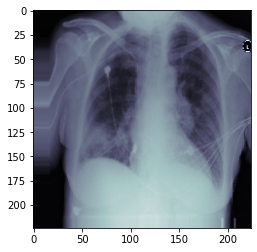

In [23]:
plt.imshow(X_train_p_o[0],cmap='bone')

## 3.2.3.Balance and generate of other decease and healthy cases

### 3.2.3.1 Function for data balancing

In [24]:
# Example usage:
# Replace 'your_dataset.csv' with your dataset file path and specify the column names and total_rows_to_select.
# balanced_data = balance_dataset(df, ['age', 'gender'], 100)
def select_balanced_dataset(df, column_names, total_rows_to_select):
    # Calculate the total number of rows you want to select
    num_groups = df.groupby(column_names).size().shape[0]
    min_records_per_group = total_rows_to_select // num_groups
    # Initialize an empty DataFrame to store the sampled rows
    balanced_df = pd.DataFrame(columns=df.columns)
    selected_indexes = []
    groupes_count = {}
    # Randomly sample from each group
    for _, group in df.groupby(column_names):
        count = group.shape[0]
        if count >= min_records_per_group:
            # If the group has enough records, sample the required number
            sample = group.sample(min_records_per_group, random_state=42)
        else:
            # If the group has fewer records than required, sample all of them
            sample = group    
        # Add the sampled rows to the balanced DataFrame
        balanced_df = pd.concat([balanced_df, sample])

        #store the index
        selected_indexes.extend(sample.index)
        
    # If you want a completely random subset, shuffle the resulting DataFrame
    balanced_df = balanced_df.sample(frac=1, random_state=42)

    return balanced_df , selected_indexes

### 3.2.3.2. Balanced selection of other than pneumonia desease cases

Pickup  ~ 2 * generated pneumonia ( ~10000 taraining case and 3000 test case) ->  25000 cases

In [25]:
decease_wo_pneumonia_df['category']

0         DECEASE_WO_PNEUMONIA
1         DECEASE_WO_PNEUMONIA
2         DECEASE_WO_PNEUMONIA
4         DECEASE_WO_PNEUMONIA
5         DECEASE_WO_PNEUMONIA
                  ...         
112096    DECEASE_WO_PNEUMONIA
112097    DECEASE_WO_PNEUMONIA
112100    DECEASE_WO_PNEUMONIA
112106    DECEASE_WO_PNEUMONIA
112108    DECEASE_WO_PNEUMONIA
Name: category, Length: 50321, dtype: object

In [26]:
#selection_number = 20000
#Due to memmory problem split reduce to 7
selection_number=2000
balanced_decease_wo_pneumonia_df,selected_index = select_balanced_dataset(decease_wo_pneumonia_df, column_names = ['Patient Age','Patient Gender','View Position' ], total_rows_to_select = selection_number)

In [27]:
len(balanced_decease_wo_pneumonia_df)

1756

In [28]:
balanced_decease_wo_pneumonia_df.head()

,Image Index,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],...,No Finding,Nodule,Edema,Consolidation,Pneumonia,Mass,Pneumothorax,Effusion,decease_number,category
60618,00014958_003.png,3,14958,18,F,PA,2392,2082,0.143,0.143,...,0,0,0,0,0,0,0,1,2,DECEASE_WO_PNEUMONIA
101117,00026848_013.png,13,26848,22,M,AP,3056,2544,0.139,0.139,...,0,0,0,0,0,0,0,0,2,DECEASE_WO_PNEUMONIA
56610,00014083_003.png,3,14083,22,F,PA,2746,2991,0.143,0.143,...,0,0,0,0,0,0,1,0,2,DECEASE_WO_PNEUMONIA
13068,00003400_004.png,4,3400,25,F,PA,2048,2500,0.171,0.171,...,0,0,0,0,0,0,1,0,1,DECEASE_WO_PNEUMONIA
3903,00001075_003.png,3,1075,59,F,AP,3056,2544,0.139,0.139,...,0,0,0,0,0,1,0,0,2,DECEASE_WO_PNEUMONIA


Check if balanced cross Gender,age and view postion

(array([868.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 888.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

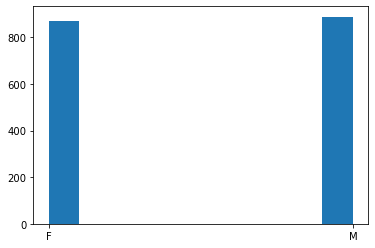

In [29]:
plt.hist(balanced_decease_wo_pneumonia_df['Patient Gender'])

(array([176., 180., 180., 200., 180., 180., 200., 180., 171., 109.]),
 array([1.0, 10.3, 19.6, 28.900000000000002, 38.2, 47.5,
        56.800000000000004, 66.10000000000001, 75.4, 84.7, 94.0],
       dtype=object),
 <a list of 10 Patch objects>)

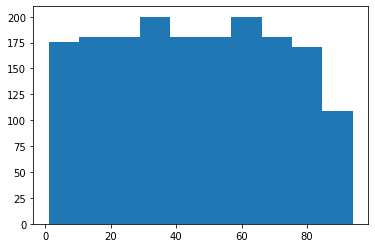

In [30]:
plt.hist(balanced_decease_wo_pneumonia_df['Patient Age'])

**Note:** there to few sample for age < 20 and >=80 to have a perfect equal rebalancing

(array([886.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 870.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

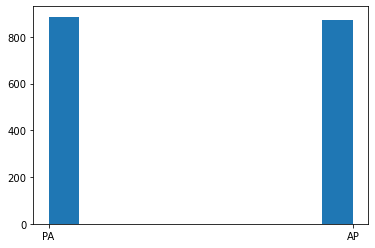

In [31]:
plt.hist(balanced_decease_wo_pneumonia_df['View Position'])

### 3.2.3.3. Initialize parameter for images generation 

In [32]:
rescale= 1/255
h_flip=False
h_shift_range=0
w_shift_range=0
rotation_range=0
shear_range=0
zoom_range=0

x_col = 'path'
y_col = 'category'
factor = 2
## for VGG16
tgt_size = (224,224)
batch_size = 64

### 3.2.3.4. generate other than pneumonia images

In [33]:
X_train_o,Y_train_o,X_test_o,Y_test_o = generate_images(df=balanced_decease_wo_pneumonia_df,
                                                      rescale = rescale,
                                                      h_flip=h_flip,
                                                      h_shift_range = h_shift_range,
                                                      w_shift_range = w_shift_range,
                                                      rotation_range= rotation_range,
                                                      shear_range= shear_range,
                                                      zoom_range=zoom_range,
                                                      x_col=x_col,
                                                      y_col=y_col,
                                                      classes=classes,
                                                      factor=factor,
                                                      tgt_size=tgt_size,
                                                      batch_size=batch_size)

Found 1405 validated image filenames belonging to 4 classes.
Found 351 validated image filenames belonging to 4 classes.
Generate 2810 train sample
Generate 702 test sample


### 3.2.3.5. Balanced selection of healthy cases

Pickup  ~ 2 * generated pneumonia ( ~10000 taraining case and 3000 test case) ->  25000 cases

In [34]:
#selection_number = 20000
#Due to memmory problem split reduce to 7
selection_number=2000
balanced_nodecease_df,selected_index = select_balanced_dataset(nodecease_df, column_names = ['Patient Age','Patient Gender','View Position' ], total_rows_to_select = selection_number)

In [35]:
len(balanced_nodecease_df)

1754

we won't complete with random data to 25000 cases

In [36]:
### 3.2.3.4. generate other than pneumonia iamges

### 3.2.3.6. generate healty images

In [ ]:
X_train_h,Y_train_h,X_test_h,Y_test_h = generate_images(df=balanced_nodecease_df,
                                                      rescale = rescale,
                                                      h_flip=h_flip,
                                                      h_shift_range = h_shift_range,
                                                      w_shift_range = w_shift_range,
                                                      rotation_range= rotation_range,
                                                      shear_range= shear_range,
                                                      zoom_range=zoom_range,
                                                      x_col=x_col,
                                                      y_col=y_col,
                                                      classes=classes,
                                                      factor=factor,
                                                      tgt_size=tgt_size,
                                                      batch_size=batch_size)

Found 1403 validated image filenames belonging to 4 classes.
Found 351 validated image filenames belonging to 4 classes.
Generate 2806 train sample


In [ ]:
#set back the CPU configuration
#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], False)

## 3.2.3. Merge data  

In [32]:
X_train_list = []
Y_train_list = []
X_train_list.append(X_train_p_p)
Y_train_list.append(Y_train_p_p)
X_train_list.append(X_train_p_o)
Y_train_list.append(Y_train_p_o)
X_train_list.append(X_train_o)
Y_train_list.append(Y_train_o)
X_train_list.append(X_train_h)
Y_train_list.append(Y_train_h)

# Merge the lists
X_train_list_merged = [image for images in X_train_list for image in images]
Y_train_list_merged = [label for labels in Y_train_list for label in labels]

# Mix and shuffle
merged_list = list(zip(X_train_list_merged,Y_train_list_merged))
random.shuffle(merged_list)

X_train, Y_train = zip(*merged_list)

# Separa

X_test_list = []
Y_test_list = []
X_test_list.append(X_test_p_p)
Y_test_list.append(Y_test_p_p)
X_test_list.append(X_test_p_o)
Y_test_list.append(Y_test_p_o)
X_test_list.append(X_test_o)
Y_test_list.append(Y_test_o)
X_test_list.append(X_test_h)
Y_test_list.append(Y_test_h)

# Merge List
X_test_list_merged = [image for images in X_train_list for image in images]
Y_test_list_merged = [label for labels in Y_train_list for label in labels]

# Mix and shuffle
merged_list = list(zip(X_test_list_merged,Y_test_list_merged))
random.shuffle(merged_list)

X_test, Y_test = zip(*merged_list)

[array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], d

In [ ]:
all_negative_indexes = data_negative_pneumothorax.index.tolist() 
left_negative_indexes = [int(i) for i in all_negative_indexes if i not in selected_negative_balanced_indexes]

In [ ]:
selected_left_negative_indexes = np.random.choice(left_negative_indexes,220 - len(negative_balanced_df) ,replace=False)

In [ ]:
#check because of weird positional indexers are out-of-bounds exception
checked_selected_left_negative_indexes=[]
for i in range(len(selected_left_negative_indexes)):
    if selected_left_negative_indexes[i] in data_negative_pneumothorax.index:
        checked_selected_left_negative_indexes.append(selected_left_negative_indexes[i])

In [ ]:
left_negative_balanced_df = data_negative_pneumothorax.loc[checked_selected_left_negative_indexes]
left_negative_balanced_df

In [ ]:
training_and_test_data  = negative_balanced_df.merge(data_positive_pneumothorax,how='outer')

In [ ]:
121104/20

## training data setup
. decease
  1. pneumonia only  300 * 7 =                   2100
  2. pneumonia with other deceasecase 1000 * 7 -> 7000
  3. no pneumonia                                 5400
. no decease                                      5500

total rec 20000

## test data
| rec num | target | percent     |
| ------- | ------ | ----------- |
| 22	  | 0,3    | 0,228642694 |
| 100	  | 1	   | 1,039284972 |
| 4400	  | 45	   | 45,72853877 | 
| 5100	  | 51	   | 53,00353357 |

total rec 9622	


In [ ]:
def create_splits(vargs):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    
    
    return train_data, val_data

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [82]:
pneumonia_pure_df

,Image Index,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],...,Infiltration,Hernia,Atelectasis,Nodule,Pneumothorax,No Finding,Consolidation,Emphysema,decease_number,category
279,00000061_015.png,15,61,77,M,AP,3056,2544,0.139000,0.139000,...,0,0,0,0,0,0,0,0,1,PNEUMONIA_PURE_DECEASE
590,00000144_001.png,1,144,83,M,AP,2500,2048,0.168000,0.168000,...,0,0,0,0,0,0,0,0,1,PNEUMONIA_PURE_DECEASE
640,00000165_001.png,1,165,76,M,PA,2992,2991,0.143000,0.143000,...,0,0,0,0,0,0,0,0,1,PNEUMONIA_PURE_DECEASE
804,00000193_019.png,19,193,55,M,AP,2500,2048,0.168000,0.168000,...,0,0,0,0,0,0,0,0,1,PNEUMONIA_PURE_DECEASE
902,00000218_001.png,1,218,33,M,PA,2048,2500,0.171000,0.171000,...,0,0,0,0,0,0,0,0,1,PNEUMONIA_PURE_DECEASE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107205,00028924_005.png,5,28924,72,F,AP,3056,2544,0.139000,0.139000,...,0,0,0,0,0,0,0,0,1,PNEUMONIA_PURE_DECEASE
108694,00029481_004.png,4,29481,51,F,AP,3056,2544,0.139000,0.139000,...,0,0,0,0,0,0,0,0,1,PNEUMONIA_PURE_DECEASE
109877,00029889_000.png,0,29889,44,F,PA,2021,2021,0.194311,0.194311,...,0,0,0,0,0,0,0,0,1,PNEUMONIA_PURE_DECEASE
110426,00030079_018.png,18,30079,16,M,AP,3056,2544,0.139000,0.139000,...,0,0,0,0,0,0,0,0,1,PNEUMONIA_PURE_DECEASE


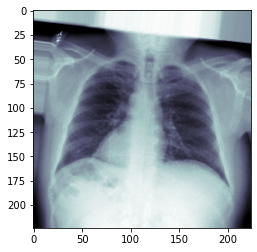

In [93]:
##fig, ax= plt.subplots( figsize = (20, 20))
plt.imshow(X_train[10],cmap='bone')

In [ ]:
len(pneumonia_pure_df)

In [ ]:
print(len(train_gen))

In [ ]:
vx,vy = train_gen.next()

In [ ]:
vx.shape

In [ ]:
## May want to pull a single large batch of random validation data for testing after each epoch:
##valX, valY = val_gen.next()

(224, 224)
[[ 22.500572   23.739912   23.270464  ...  93.3948     93.82581
   94.       ]
 [ 21.791748   21.329092   19.206577  ...  94.         94.
   94.45141  ]
 [ 10.191543    9.1342745   7.2502193 ...  98.66509    99.52713
  100.12972  ]
 ...
 [  0.          0.          1.2095956 ... 134.        134.
  134.       ]
 [  0.          0.         25.286032  ... 134.        134.
  134.       ]
 [  0.          0.         27.845911  ... 134.        134.
  134.       ]]
(224, 224)
[[  2.          2.          2.        ...   2.          2.
    2.       ]
 [  2.          2.          2.        ...   2.          2.
    2.       ]
 [  2.          2.          2.        ...   2.          2.
    2.       ]
 ...
 [125.94387   128.75633   130.7554    ...  17.         16.97149
   16.573757 ]
 [127.30817   128.76738   129.85419   ...  16.771505   17.
   17.       ]
 [128.46968   130.42537   132.12268   ...  15.210839   15.0543165
   15.319471 ]]
(224, 224)
[[10.       10.       10.       ... 10.      

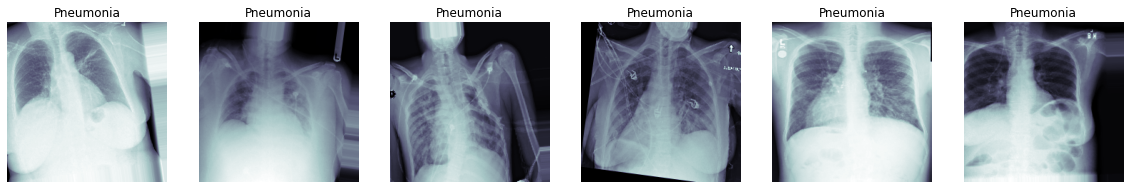

In [75]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_generator)
fig, m_axs = plt.subplots(1, 6, figsize = (20, 20))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    print(c_x[:,:,0].shape)
    print(c_x[:,:,0])
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [ ]:
def load_pretrained_model(vargs):
    
    # model = VGG16(include_top=True, weights='imagenet')
    # transfer_layer = model.get_layer(lay_of_interest)
    # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    
    return vgg_model


In [ ]:
def build_my_model(vargs):
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    
    return my_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [ ]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

# weight_path="{}_my_model.best.hdf5".format('xray_class')

# checkpoint = ModelCheckpoint(weight_path, 
#                              monitor= CHOOSE_METRIC_TO_MONITOR_FOR_PERFORMANCE, 
#                              verbose=1, 
#                              save_best_only=True, 
#                              mode= CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC, 
#                              save_weights_only = True)

# early = EarlyStopping(monitor= SAME_AS_METRIC_CHOSEN_ABOVE, 
#                       mode= CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC, 
#                       patience=10)

# callbacks_list = [checkpoint, early]

### Start training! 

In [ ]:
## train your model

# Todo

# history = my_model.fit_generator(train_gen, 
#                           validation_data = (valX, valY), 
#                           epochs = , 
#                           callbacks = callbacks_list)

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [ ]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = new_model.predict(valX, batch_size = 32, verbose = True)

In [ ]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    
    return

## what other performance statistics do you want to include here besides AUC? 


# def ... 
# Todo

# def ...
# Todo
    
#Also consider plotting the history of your model training:

def plot_history(history):
    
    # Todo
    return

In [ ]:
## plot figures

# Todo

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [ ]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo

In [ ]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

# fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
# i = 0
# for (c_x, c_y, c_ax) in zip(valX[0:100], testY[0:100], m_axs.flatten()):
#     c_ax.imshow(c_x[:,:,0], cmap = 'bone')
#     if c_y == 1: 
#         if pred_Y[i] > YOUR_THRESHOLD:
#             c_ax.set_title('1, 1')
#         else:
#             c_ax.set_title('1, 0')
#     else:
#         if pred_Y[i] > YOUR_THRESHOLD: 
#             c_ax.set_title('0, 1')
#         else:
#             c_ax.set_title('0, 0')
#     c_ax.axis('off')
#     i=i+1

In [ ]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)